<Body>   
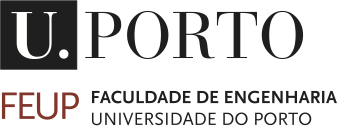   
<h1> <b>Computer Vision 2022/2023 </b> </h1>
<p><b>Andry Maykol Pinto </b> (amgp@fe.up.pt)</p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  
FEUP

---

# **Introduction to Object Detection and Recognition**

<h2>Table of contents</h2>
<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
    <li><a href="#ref1">Single detection: Visual Bag of Words</a></li>
    <li><a href="#ref2">Single detection: Support Vector Machine</a></li>
    <li><a href="#ref3">Multi-Object Detection</a></li>
</ol>
<p></p>
</div>
<hr>


# **Single Object Recognition**

The simplest task in object recognition is to handle a single object at a time:

![](https://drive.google.com/uc?export=view&id=10HuNzfck3OdwSJNhKHlISN3LPyb5QV4V)



<a id="ref1"></a>
# 1. **Visual Bag of Words**

To achieve this end we are going to code a **Visual Bag of Words** (VBoW) from scratch. As we've seen, this entails three distinct steps:

1. Extraction of features and descriptors
2. Learning the codewords dictionary
3. Vector quantization

Before we start, please run the following pip command to ensure that the opencv library is up to the required version.

In [ ]:
pip install opencv-contrib-python==4.5.3.56

Unfortunately, we're not going to use a cute puppy dataset, we are instead using the very well known MNIST dataset: https://en.wikipedia.org/wiki/MNIST_database

This dataset is considered the "Hello World" of machine learning, being composed of 60,000 training instances and 10,000 testing instances, all of handwritten numbers.

![](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Let's start by loading the dataset and getting acquainted with the data format:

In [ ]:
import cv2
import matplotlib.pyplot as plt
from keras.datasets import mnist

#load MNIST dataset, already split into train and test set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#From the 60k training instances, we're only using half to easy up on the time it will take to train our models
x_train = x_train[:30000]
y_train = y_train[:30000]

# How is out dataset split?
print("Training instances:", len(x_train))
print("Testing instances:",  len(x_test), "\n")

#get acquainted with the data we're using:

# x holds the grayscale image information
plt.gray()
plt.matshow(x_train[999])
plt.show()

# y holds the label - in this case, a number from 0 to 9
print("This number is a", y_train[999])

Feel free to test out some other images with the code snippet above.

Now that we have our data ready to go, let's tackle task number 1: Extract features and descriptors. 

For that let's employ the SIFT algorithm. 

In [ ]:
# Calculate a set of features from our x_train set, using the SIFT

#Create a SIFT object
sift = cv2.xfeatures2d.SIFT_create(100)

#Iterate through the x_train list and obtain a list of keypoints and descriptors
keypoints = []
descriptors = []

for img in x_train:
    kps, des = sift.detectAndCompute(img, None)
    keypoints.append(kps)
    descriptors.append(des)


Let's try and visualize some of the keypoints we've calculated now:

In [ ]:
import pandas as pd

#Create a dataframe to easy handling of the data
df = pd.DataFrame()
df["kps"] = keypoints
df["des"] = descriptors
df["label"] = y_train
df.tail()

#How many keypoints did SIFT obtain for the instance number 0?
print("Number of keypoints:", len(df.kps[0]))

plt.figure(figsize=(15, 9))
plt.subplot(2, 2, 1)
plt.imshow(x_train[0], cmap='gray')
pts_x = [kp.pt[0] for kp in df.kps[0]]
pts_y = [kp.pt[1] for kp in df.kps[0]]
plt.scatter(pts_x[:], pts_y[:], s=200, c='r')
plt.axis('off')

print("Points:")
for i in range(len(df.kps[0])):
  print("Point ", i+1, ": ", pts_x[i], ",", pts_y[i])

plt.tight_layout()
plt.show()

Keep in mind that each of the keypoints is represented by a set of 128 descriptors. 

Now that we have extracted a set of features from the dataset, we can move on to task number 2: Learn the codewords dictionary. 

For that we are going to use the **K-means** algorithm. The objective here is to group together similar features into a set of clusters. Note that the number of clusters **k we define is directly propotional to both the accuracy (be aware of possible overfitting) and the time it takes to compute a solution.**

With that said, the next code snippet will take about 5 minutes to compute a solution, with k=50. 




In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Exclude images from which feature points cannot be extracted from the dataset
df = df.dropna() 
df = df.reset_index(drop = True)

# Append all the descriptors into a single vector
dsc_train_vec = [] 
for des in df.des: 
  for d in des:        
    dsc_train_vec.append(d) 

dsc_train_vec = np.asarray(dsc_train_vec)

# Define and train our K-means model:
K = 50 #number of clusters
model_clu = KMeans(n_clusters=K, init="k-means++", random_state = 42).fit(dsc_train_vec)

Each of our descriptors now belongs to a cluster. 

The next step is to build a histogram of length k (the number of clusters generated from k-means), where the ith value in the histogram is the
frequency of the ith visual codeword:


In [ ]:
def vbow_vectorizer(des):
    # Assign a cluster to each of our descriptors
    clu_nums = model_clu.predict(des.reshape(-1, 128))
    # Return the histogram count of each cluster
    return np.bincount(clu_nums, minlength=K)

vbow_hist_train = []

for des in df.des:
    vbow_hist_train.append(vbow_vectorizer(des))

# To further understand this step let's look at this example:
# Our K-means model is going to predict a cluster for each of the keypoints extracted from image 78:
print("K-means prediction for each keypoint: ", model_clu.predict(df.des[77].reshape(-1, 128)))
# Now let's see how our histogram looks:
print("Histogram of image 78: \n", vbow_hist_train[77], "\n")

print("We can see that we have 1 keypoint in cluster 6, 3 keypoints in cluster 19, 1 keypoint in cluster 23, another keypoints in cluster 32, and finally 2 keypoints in cluster 37.")
print("And this is exactly the information translated in our histogram.")



Finally, with our information quantized, we can treat the frequency histogram of codewords as the feature vector for a standard classifier and use it to learn a classification model for our set of handwritten numbers.

As an example let's start by using a Naive Bayes approach:

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. Bayes’ theorem states the following relationship, given class variable **$y$** and dependent feature vector **$x_1$** through $x_n$:

$P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots, x_n \mid y)}{P(x_1, \dots, x_n)}$

Using the naive conditional independence assumption that:

$P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n) = P(x_i | y),$

for all $i$, this relationship is simplified to:

$P(y \mid x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i \mid y)}
                                 {P(x_1, \dots, x_n)}$

Since $P(x_1, \dots, x_n)$ is constant given the input, we can use the following classification rule:         

$\begin{align}\begin{aligned}P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)\\\Downarrow\\\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y),\end{aligned}\end{align}$

and we can use Maximum A Posteriori (MAP) estimation to estimate $P(y)$ and $P(x_i \mid y)$; the former is then the relative frequency of class $y$ in the training set.

The different naive Bayes classifiers differ mainly by the assumptions they make regarding the distribution of $P(x_i \mid y)$.

Source: https://scikit-learn.org/stable/modules/naive_bayes.html


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Use the updated label vector since we droped a few instances that had no features. 
# This is our ground truth
y_trueNB = df.label

# Create the classifier object and train the model with our histogram and corresponding labels
model_NB = MultinomialNB().fit(np.asarray(vbow_hist_train), y_trueNB)

# Now to obtain the predictions from our NB model:
y_pred = model_NB.predict(vbow_hist_train)

# We can now review some classification metrics to check out our training:
print(classification_report(y_trueNB, y_pred))


# Exercise 1
a) How could we improve our training results?

b) Implement a code snippet that allows you to test out this model with our **test** partition of the dataset. Keep in mind that you do not have to retrain the models, only make the predictions for the x_test vector.

c) Evaluate the model's results in terms of precision, recall and f1-score (**without resorting to pre-coded functions**). 

d) What conclusions can you infer from comparing the obtained testing metrics with our previous training results?

In [ ]:
#b)

#Iterate through the x_test list and obtain a list of keypoints and descriptors
keypoints_test = []
descriptors_test = []

for img in x_test:
    kps, des = sift.detectAndCompute(img, None)
    keypoints_test.append(kps)
    descriptors_test.append(des)

#...
#...


print(classification_report(y_true_test, y_pred_test))

In [ ]:
#c)

TP = []
FP = []
FN = []

for label in range(10):
  true_positives = false_negatives = false_positives = 0
  #...
  #...

#...
#...


#Precision per class:
precision = np.array(TP)/(np.array(TP) + np.array(FP))

#Recall per class:
recall = np.array(TP)/(np.array(TP) + np.array(FN))

#F1-score per class:
f1 = 2 * (precision * recall)/(precision + recall)

for i in range(10):
  print("Class ", i,":")
  print("          Precision: ",precision[i], " Recall: ", recall[i], " F1-Score: ", f1[i])


avg_precision = np.sum(np.array(precision))/len(precision)
avg_recall = np.sum(np.array(recall))/len(recall)
avg_f1 = np.sum(np.array(f1))/len(f1)

print("\n")
print("Average Precision: ", avg_precision, " Average Recall: ", avg_recall, " Average F1-Score: ", avg_f1)

#print(classification_report(y_true_test, y_pred_test))

<a id="ref2"></a>
# 2. **Support Vector Machine - SVM**

Let's look at a more powerfull tool now. Instead of calculating features from our input *a priori*, an SVM is capable of exctracting features directly from the data, exploiting existing patterns.

The basic idea of support vector machines is: 

-> Calculate an optimal hyperplane for linearly separable patterns;

![](https://drive.google.com/uc?export=view&id=1S1wu9WxN21q84f0Q6r7UP01xSU8JMiPr)


SVMs maximize the margin around the separating hyperplane. The decision between two classes is fully specified by a subset of training samples: **the support vectors**.

**But what if the data is not linearly separable?**

![](https://drive.google.com/uc?export=view&id=1WpZt8ZfEpK0TU_tTr_hXjKQEskt8skTz)

-> Extend to patterns that are not linearly separable by transformations of original data to map into new space – **the Kernel function**.

![](https://drive.google.com/uc?export=view&id=129QOpaW86vI9UHgjKtDhc5DLgaTeUGOT)




Source: http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf


The following code snippet takes about 8 minutes to compute a solution. 



Let's implement an SVM classifier capable of recognizing which number is contained in our MNIST images:


In [ ]:
from sklearn import svm

# We need to flatten our our input images so they can be processed by the SVM.
# The downside here is that we are losing some of the space correlations between pixels.
x_train_flat = x_train.reshape(len(x_train),-1)

print("Shape of input data: ",x_train_flat.shape)

#Create an svm Classifier
svm_clf = svm.SVC(kernel='linear', C=1, random_state = 42) # Linear Kernel

# Train the model using the training set
svm_clf.fit(np.asarray(x_train_flat), y_train)

# Predict the response for the train dataset
y_pred = svm_clf.predict(np.asarray(x_train_flat))

# Check out the training results
print(classification_report(y_train, y_pred))

# Exercise 2
a) How does the SVM fare within the test partition of our data? Compare it with the results obtained with the VBoW in terms of Precision, Recall and F1-score. 

b) Implement a code snippet that allows you to make a prediction on your own handwritten numbers (draw them in paint to ease up the process). Did it make a correct prediction? If not, comment on why this might have happened.

c) Load the following images into your colab cell:
 1. 6_black.png
 2. 6_white.png

Make a prediction for both images, comment on the results.

In [ ]:
#Solution

#a)
x_test_flat = x_test.reshape(len(x_test),-1)
print("Shape of input data: ",x_test_flat.shape)

#...
#...

In [ ]:
#b)/c)

from google.colab import files
uploaded = files.upload()

In [ ]:
#b/c cont.)

# Read input image into opencv
input_img = cv2.imread('6_black.png')

# Convert the image into grayscale
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

# Resize the image into the same size (28x28) of the MNIST dataset images
input_img = cv2.resize(input_img, (28,28))

#...
#...

<a id="ref3"></a>
# **Multi Object Detection**

A much more complex task is to detect diverse objects within unconstrained scenarios. To achieve this we are going to employ a state-of-the-art deep convolutional network that is able of learning robust and high-level feature representations of an image directly from the input data.

![](https://drive.google.com/uc?export=view&id=17Xn57WiLWh9LZmRfSogMP4DgzCvjeIuz)

The network we are going to use is called YOLO v3:
https://github.com/ultralytics/yolov3.

Before we start, let's allow google colab to use the machine's GPU:

>**Go to Runtime -> Change runtime type -> Hardware accelarator -> GPU**

After this step, run the following cell to set up the environment.

The output should be something like this:
> Setup complete. Using torch 1.9.0+cu111 (#Name_of_GPU)


In [ ]:
!git clone https://github.com/ultralytics/yolov3  # clone repo
%cd yolov3
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!python detect.py --weights yolov3.pt --img 640 --conf 0.35 --source ./viana_1.jpg
Image(filename='runs/detect/exp/viana_1.jpg', width=600)


# Exercise 3

a) Test out some of your own images. How many objects did the algorithm detect? What is the probability associated with each one?

Note: To visualize the algorithms predictions pay attention to where it saves the output: Results saved to runs/detect/exp...

